## 1. Imports

We start with importing all relevant dependencies and getting the data in an aggegated format. This is done within the `get_data.py` script where create a dataset containing all $100$ files using a Multi-Index on the relevant fields `Year`, `Month`, `Day` and `File Index`. We get a first look at the data with its dimensions and show the first lines to get an overview over the strucutre of the data:

In [1]:
from src.get_data import create_df
from src.get_plots import seasonal_trends, regional_trends
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import torch
from tqdm import tqdm

In [2]:
data = create_df()

print('Dataset has {} rows and {} columns'.format(len(data.index), len(data.columns)))
data.head()

2025-01-07 23:28:46,568 - INFO - Dataframe created successfully.


Dataset has 1424400 rows and 23 columns


DOY  2m_temp_max  2m_temp_mean  2m_temp_min  \
year month day region                                                
1981 1     1   9         1         -5.6          -7.8        -11.2   
               19        1         -0.1          -3.5         -7.5   
               22        1         -3.4          -6.5         -9.4   
               24        1         -2.5          -5.3         -8.0   
               30        1          1.1          -1.9         -5.5   

                       2m_dp_temp_max  2m_dp_temp_mean  2m_dp_temp_min  \
year month day region                                                    
1981 1     1   9                 -7.7            -11.4           -16.4   
               19                -2.0             -6.1           -11.4   
               22                -4.9             -8.6           -13.2   
               24                -4.1             -7.3           -11.2   
               30                -0.9             -4.2            -8.5   

                       10m_wind_u  10m_wind_v  fcst_alb  ...  \
year month day region                                    ...   
1981 1     1   9              0.4         0.2      0.51  ...   
               19             1.5         0.9      0.47  ...   
               22             1.0         0.7      0.43  ...   
               24             1.7         0.9      0.44  ...   
               30             2.8         1.2      0.40  ...   

                       surf_net_solar_rad_max  surf_net_solar_rad_mean  \
year month day region                                                    
1981 1     1   9                           81                       13   
               19                         100                       14   
               22                          94                       14   
               24                          91                       15   
               30                         112                       17   

                       surf_net_therm_rad_max  surf_net_therm_rad_mean  \
year month day region                                                    
1981 1     1   9                           33                       11   
               19                          54                       20   
               22                          44                       20   
               24                          47                       22   
               30                          61                       28   

                       surf_press  total_et   prec  volsw_123  volsw_4  \
year month day region                                                    
1981 1     1   9            84236     -0.05  10.94       0.37     0.43   
               19           92665     -0.10   7.85       0.34     0.40   
               22           86233     -0.12  10.02       0.33     0.40   
               24           87064     -0.07  10.91       0.33     0.40   
               30           93880      0.06   9.54       0.35     0.40   

                            date  
year month day region             
1981 1     1   9      1981-01-01  
               19     1981-01-01  
               22     1981-01-01  
               24     1981-01-01  
               30     1981-01-01  

[5 rows x 23 columns]

## 2. Data Exploration

Next, we will look at the data in three stages:

1. Null Values Analysis
2. Statistical Analysis
3. Data Preprocessing

### 2.1 Null Values Analysis

As we can see, we do not have any missing values in the data. However, we can see that there are many entries with a value $=0$ which require further investigation!

In [3]:
missing_vals = int(data.isna().sum(axis=0).sum())
zero_vals = int((data == 0).sum(axis=0).sum())
print('We have {} missing values in the dataset.\nWe have {} zero values in the dataset.'.format(missing_vals, zero_vals))

We have 0 missing values in the dataset.
We have 1084766 zero values in the dataset.


Seeing that we have many zeros values, we want to investigate to what extend the zero values are plausable and if not, whether there are some systematic processes behind values being zero. Therefore, we first look at how zero values are distributed along the columns:

In [4]:
zero_cols = (data == 0).sum(axis=0).sort_values(ascending=False)
pd.DataFrame(zip(zero_cols, zero_cols/len(data.index)*100), 
                                columns=['Abs. Count','Rel. Count (%)'],
                                index= zero_cols.index)

,Abs. Count,Rel. Count (%)
swe,603866,42.394412
prec,275788,19.361696
10m_wind_u,70340,4.938220
10m_wind_v,61991,4.352078
total_et,35376,2.483572
2m_temp_min,6685,0.469320
2m_dp_temp_mean,6341,0.445170
2m_dp_temp_max,6155,0.432112
2m_temp_mean,6092,0.427689
2m_dp_temp_min,5943,0.417228


As we can see, the zero values are spread among a set of variables. For some, zero values are plausible while for others we cannot expect zero values to occur. Therefore we will next go through the variables one by one:

- **swe**: Water equivalent of snow measures the water amount in snow. Since snow is limited to Winter in our climate sphere, the zero values seem plausible!
- **prec**: Since this is the total amount of precipitation, we can assume the zero values to be plausible meaning that it was not raining.
- **10m_wind_(u/v)**: Since is is logical that there are times with no wind present, we also can assume there zero values being plausible!

### 2.2 Statistical Analysis


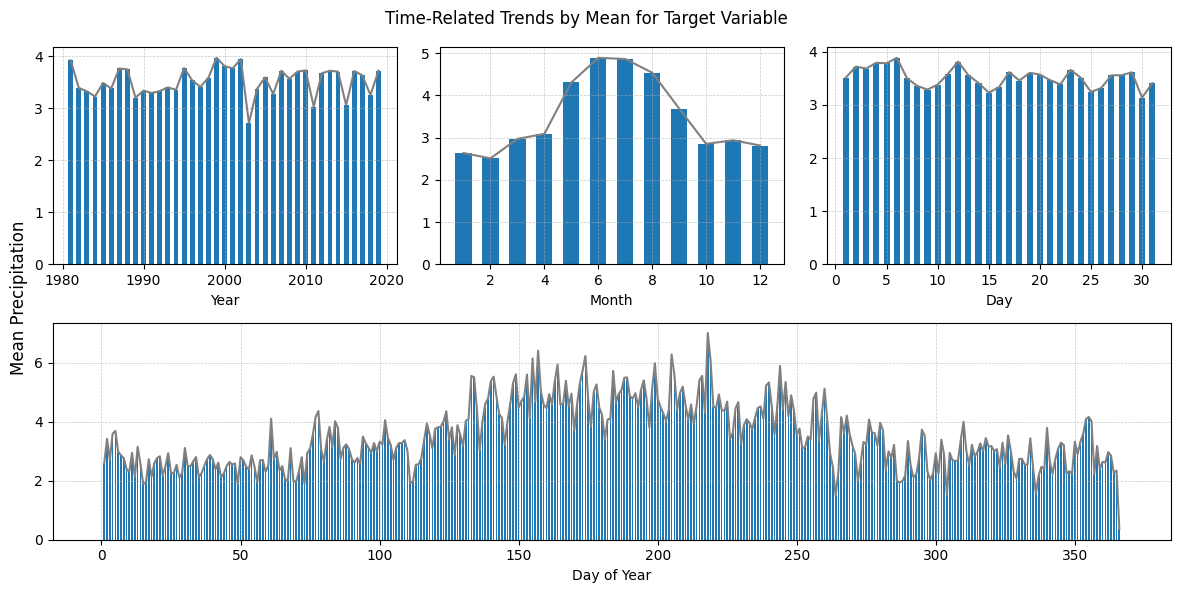

In [5]:
seasonal_trends(data, 'mean')

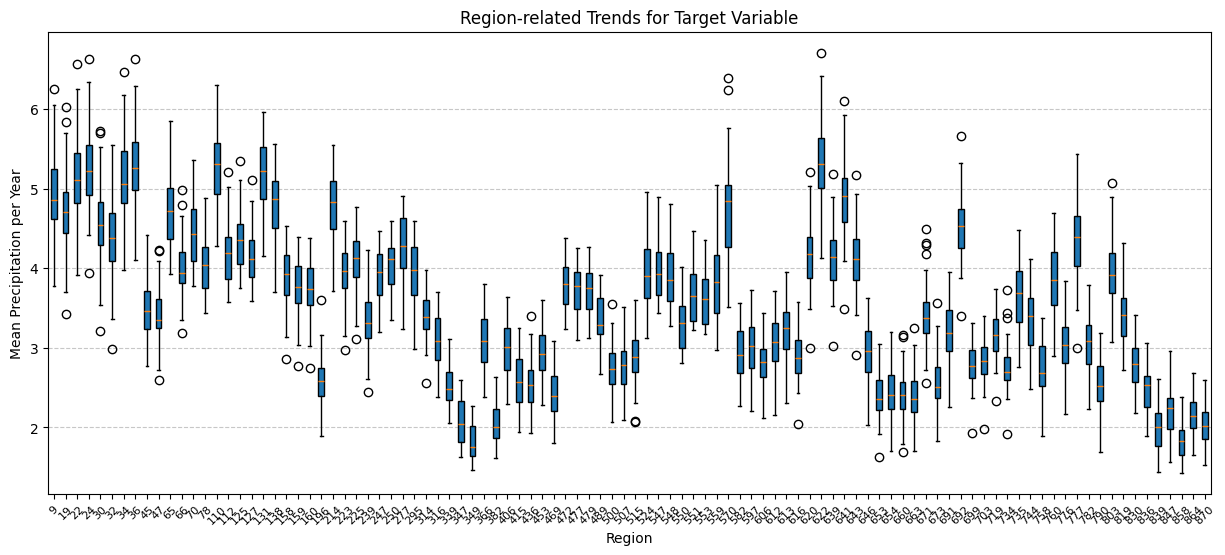

In [6]:
regional_trends(data, 'mean')

### 2.3 Data Preprocessing

In [7]:
def split_data(df:pd.DataFrame, split:float=0.7):
    # Compute the number of unique primary keys (e.g., years or regions) for splitting
    unique_keys = df.index.get_level_values(0).unique()  # Assuming `year` is the first level
    num_train_keys = round(len(unique_keys) * split)

    # Exogenous variables
    drop_cols = [col for col in df.columns if (col.endswith('max') or col.endswith('min'))]
    drop_cols.extend(['DOY', '2m_dp_temp_mean', 'lai_low_veg'])
    df = df.drop(columns=drop_cols)


    # Split the keys
    train_keys = unique_keys[:num_train_keys]
    test_keys = unique_keys[num_train_keys:]

    # Split the DataFrame based on the keys
    train = df.loc[train_keys]
    test = df.loc[test_keys]

    assert len(test.index) > 0

    return train, test


train, test = split_data(data)

In [8]:
from sklearn.preprocessing import StandardScaler

# Assume df_train and df_test are your dataframes
columns_to_scale = train.columns.difference(['date', 'prec']) 

# Initialize the scaler
scaler = StandardScaler()

# Scale only the selected columns
train_scaled = train.copy()
test_scaled = test.copy()

train_scaled[columns_to_scale] = scaler.fit_transform(train_scaled[columns_to_scale])
test_scaled[columns_to_scale] = scaler.transform(test_scaled[columns_to_scale])

## 3. Modelling

In [9]:
from src.training_utils import get_errors

### 3.1 Baseline Model

For a basic approach, I want to combine naive approaches for temporal and regional dynamics. Hereby, we define our model like:

$$Y_{t,x} = \beta_0 s(t,x) + \sum_{k=1}^{p} \phi_k y_{t-k} + \beta_1 X_{1,t,x} + \dots + \beta_k X_{k,t,x} + \epsilon $$

First, I estimate seasonal developments by looking at the distribution of precipiation for the same day for each region seperately.


- Lagged outcomes
- mutiple input features for different timesteps
- Interaction of time and region

In [10]:
from src.baseline import Linear_Baseline

baseline = Linear_Baseline(n_lags=1)
baseline.fit(train_scaled.drop(columns=['prec', 'date']), train_scaled.prec)
pred, truth = baseline.predict(test_scaled.drop(columns=['prec', 'date']), test_scaled.prec)

In [11]:
get_errors(pred, truth)

{'RMSE': 4.593172550201416, 'MSE': 21.09723472595215}

### 3.2 Hierarchical Modelling
A more sophisticated approach is to model the data using a Bayesian Framework with allows each region to be modelled independently with its own parameters. That way, the model can be defined as:

$$\mu_{r,t} = \alpha_r + \sum_{k=1}^{p} \phi_k y_{t-k} + \beta X_t + \sum_{j=1}^{J} \left( \gamma_j \sin \left( \frac{2\pi j t}{365} \right) + \delta_j \cos \left( \frac{2\pi j t}{365} \right) \right)$$

$$log(y_{r, t}) \sim \text{Normal}(\mu_{r,t}, \sigma_r)$$

In [25]:
# training takes lots of time, feel freee to skip...
from src.hierarchical import HierarchicalModel
model = HierarchicalModel(n_lags=2, n_season=3)
fit = model.fit(train, columns_to_scale)
model.save('model_new')

CmdStan install directory: /Users/anton/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /var/folders/jv/4gp8sv9n0llcgzyj3vts85nr0000gn/T/tmpxwi_q0a5
Extracting distribution


2025-01-07 22:45:42,445 - DEBUG - cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


2025-01-07 22:47:28,895 - DEBUG - cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


2025-01-07 22:47:36,675 - DEBUG - Removing /Users/anton/Documents/University/Master/Semester_5/Sustainable_AI/precipitation_pred/anton/src/model_b
22:47:36 - cmdstanpy - INFO - compiling stan file /Users/anton/Documents/University/Master/Semester_5/Sustainable_AI/precipitation_pred/anton/src/model_b.stan to exe file /Users/anton/Documents/University/Master/Semester_5/Sustainable_AI/precipitation_pred/anton/src/model_b
2025-01-07 22:47:36,677 - INFO - compiling stan file /Users/anton/Documents/University/Master/Semester_5/Sustainable_AI/precipitation_pred/anton/src/model_b.stan to exe file /Users/anton/Documents/University/Master/Semester_5/Sustainable_AI/precipitation_pred/anton/src/model_b
2025-01-07 22:47:36,678 - DEBUG - cmd: make STANCFLAGS+=--filename-in-msg=model_b.stan /Users/anton/Documents/University/Master/Semester_5/Sustainable_AI/precipitation_pred/anton/src/model_b
cwd: /Users/anton/.cmdstan/cmdstan-2.36.0
2025-01-07 22:47:45,880 - DEBUG - Console output:

--- Translating 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-01-07 22:47:55,672 - DEBUG - idx 0
2025-01-07 22:47:55,675 - DEBUG - running CmdStan, num_threads: 1
2025-01-07 22:47:55,675 - DEBUG - idx 2
2025-01-07 22:47:55,675 - DEBUG - idx 1
2025-01-07 22:47:55,676 - DEBUG - idx 3
2025-01-07 22:47:55,681 - DEBUG - running CmdStan, num_threads: 1
2025-01-07 22:47:55,678 - DEBUG - running CmdStan, num_threads: 1
2025-01-07 22:47:55,682 - DEBUG - CmdStan args: ['/Users/anton/Documents/University/Master/Semester_5/Sustainable_AI/precipitation_pred/anton/src/model_b', 'id=3', 'random', 'seed=10', 'data', 'file=/var/folders/jv/4gp8sv9n0llcgzyj3vts85nr0000gn/T/tmp5nyewx9x/ipruu9qw.json', 'output', 'file=/var/folders/jv/4gp8sv9n0llcgzyj3vts85nr0000gn/T/tmp5nyewx9x/model_by_m4znmi/model_b-20250107224755_3.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
2025-01-07 22:47:55,676 - DEBUG - CmdStan args: ['/Users/anton/Documents/University/Master/Semester_5/Sustainable_AI/precipitation_pred/anton/src/model

23:21:09 - cmdstanpy - INFO - CmdStan done processing.
2025-01-07 23:21:09,516 - INFO - CmdStan done processing.
2025-01-07 23:21:09,516 - DEBUG - runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/anton/Documents/University/Master/Semester_5/Sustainable_AI/precipitation_pred/anton/src/model_b', 'id=1', 'random', 'seed=10', 'data', 'file=/var/folders/jv/4gp8sv9n0llcgzyj3vts85nr0000gn/T/tmp5nyewx9x/ipruu9qw.json', 'output', 'file=/var/folders/jv/4gp8sv9n0llcgzyj3vts85nr0000gn/T/tmp5nyewx9x/model_by_m4znmi/model_b-20250107224755_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/jv/4gp8sv9n0llcgzyj3vts85nr0000gn/T/tmp5nyewx9x/model_by_m4znmi/model_b-20250107224755_1.csv
 console_msgs (if any):
	/var/folders/jv/4gp8sv9n0llcgzyj3vts85nr0000gn/T/tmp5nyewx9x/model_by_m4znmi/model_b-20250107224755_0-stdout.txt
2


Parameters saved sucessfully!


In [17]:
model = HierarchicalModel(n_lags=2, n_season=3)
model.load('model_final')
pred, truth = model.predict(test)
get_errors(pred.flatten(), truth.flatten())

Parameters loaded sucessfully!


{'RMSE': 6.3195490418808875, 'MSE': 39.936700092737645}

As we can see, the performance is not good. However, we can see that there are big differences for different regions! Hence, future models should try to better incorporate the regional differences, however in most scenarios that would mean more parameters which I could not do at the moment.

In [32]:
print('Errors per Region: \n{}'.format(np.sqrt(np.pow(truth - pred, 2).sum(axis=1) / truth.shape[1])))

Errors per Region: 
[ 7.8385895   7.86560722  8.21643772  8.33681553  7.6210581   7.5372834
  8.01659182  8.10297732  6.25299914  6.02239355  7.66711729  6.4446644
  7.4230876   6.95520135  8.24198257  7.28922073  7.65132668  7.5442116
  8.00387498  7.66087809  6.67842795  6.44648134  6.39636047  4.80631364
  7.6556818   6.76643792  6.84133449  5.90153351  6.49992494  6.67878086
  7.15666078  6.81156012  4.93100991  5.57050677  4.7157035   4.33050099
  3.89539896  5.86420739  4.09696502  5.72847707  5.24801703  5.13456269
  5.65896509  5.07755868  6.63809091  6.36672453  6.39719244  6.21145493
  5.43014122  5.66684213  6.24660211  7.97621793  7.49058727  7.32854124
  6.51666775  7.19121411  7.00633085  8.35453327 10.67630759  5.93981093
  6.63214445  5.77772295  4.82356819  5.01238522  4.44435823  6.64027697
  8.24808361  6.51570303  7.86420159  6.80606692  5.24912615  4.20662609
  4.3878759   4.15825321  4.20730024  5.59774395  4.49692799  5.47240271
  7.3584257   4.90717093  4.983912

In [39]:
model = HierarchicalModel(n_lags=2, n_season=3)
model.load('model_final')
pred, truth = model.predict(test)
get_errors(pred.flatten(), truth.flatten())

Parameters loaded sucessfully!


{'RMSE': 6.848418733711332, 'MSE': 46.90083915224833}